<a href="https://colab.research.google.com/github/Joshuajee/AI-ML-PROJECTS/blob/master/deeplearning/image classification/Tool Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Remove randomness
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ["TF_DETERMINISTIC_OPS"] = "1"

In [2]:
import os
import random
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Remove randomness
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ["TF_DETERMINISTIC_OPS"] = "1"

In [3]:
# Dataset parameters
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/train",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=123,
)

Found 249 files belonging to 10 classes.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/validation",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=123,
)

Found 83 files belonging to 10 classes.


In [5]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/test",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=123,
)

Found 86 files belonging to 10 classes.


In [6]:
class_names = train_ds.class_names
class_names

['allen key',
 'chisel',
 'hammer',
 'mallet',
 'plier',
 'saw',
 'scrapper',
 'screw driver flat',
 'screw driver star',
 'spanner']

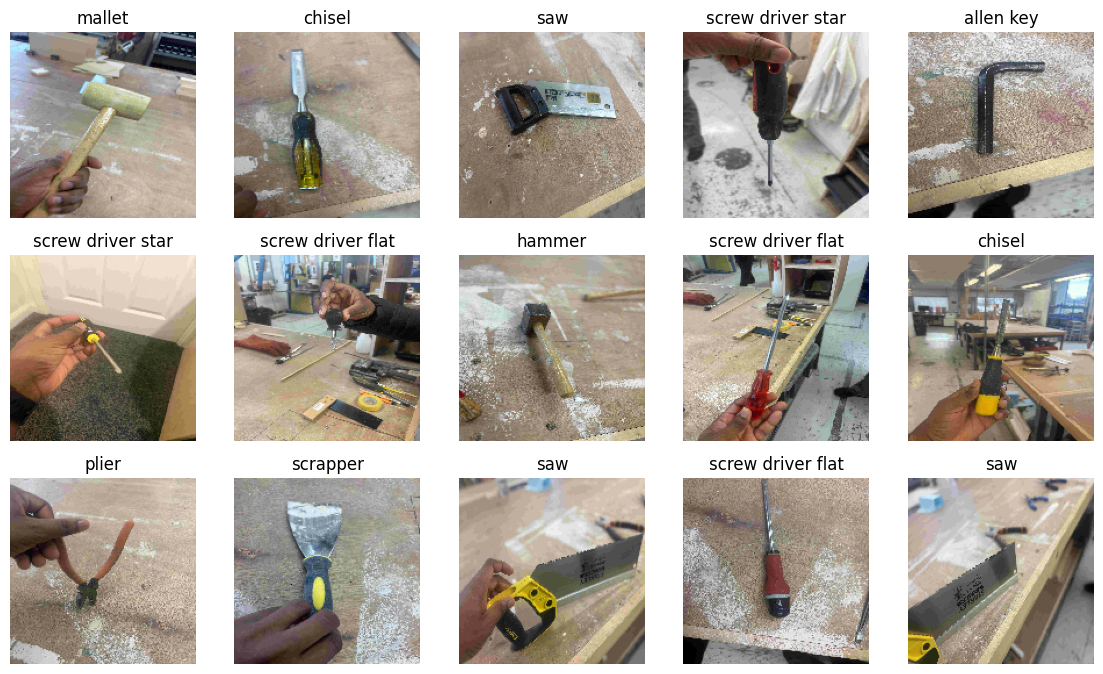

In [7]:
plt.figure(figsize=(14, 14))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of train batches: 8
Number of validation batches: 3
Number of test batches: 3


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

Because I don't have a large image dataset, I'm to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduces overfitting

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness(factor=0.2),
  tf.keras.layers.RandomContrast(factor=0.2)
])

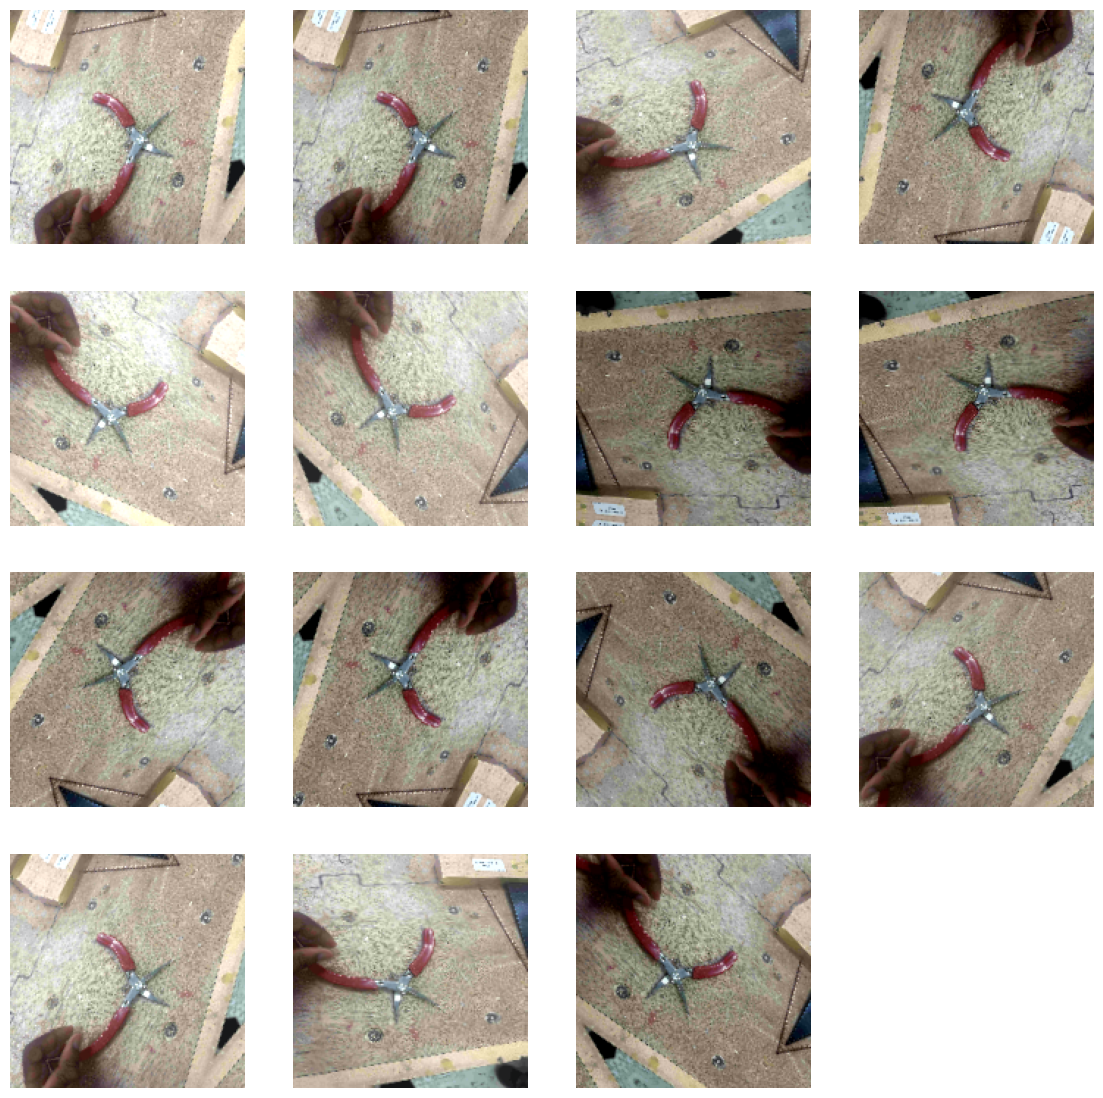

In [11]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(14, 14))
  first_image = image[0]
  for i in range(15):
    ax = plt.subplot(4, 4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Building the models



In [12]:
def classifer_model(is_mobilenet, base_learning_rate, fine_tune=False):

    # Create the base model from the pre-trained model MobileNet V2
    IMAGE_SHAPE = IMG_SIZE + (3,)

    if is_mobilenet:
        base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    else:
        base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)
        preprocess_input = tf.keras.applications.inception_v3.preprocess_input

    image_batch, _ = next(iter(train_ds))
    feature_batch = base_model(image_batch)

    network_depth = len(base_model.layers)

    print("Number of layers in the base model: ", network_depth)

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = int(network_depth * 0.3) # fine tune 30% of the network
        # Freeze all the layers before the `fine_tune_at` layer
        print("Fine Tuning at: ", fine_tune_at)
        for layer in base_model.layers[:fine_tune_at]:
          layer.trainable = False
    else:
        base_model.trainable = False # Freeze all the layers of the model

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    prediction_layer = tf.keras.layers.Dense(10, activation='softmax')
    prediction_batch = prediction_layer(feature_batch_average)

    inputs = tf.keras.Input(shape=(160, 160, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    model.summary()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model



### Model Test

In [13]:
learning_rate = 0.0001
epochs = 100
mobile_netv2 = classifer_model(True, learning_rate)

Number of layers in the base model:  154


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
inception_v3 = classifer_model(False, learning_rate)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of layers in the base model:  311


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,823,274 (83.25 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [15]:
mobile_netv2_finetune = classifer_model(True, learning_rate, True)

Number of layers in the base model:  154
Fine Tuning at:  46


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 2,189,898 (8.35 MB)

 Non-trainable params: 80,896 (316.00 KB)

In [16]:
inception_v3_finetune = classifer_model(False, learning_rate, True)

Number of layers in the base model:  311
Fine Tuning at:  93


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,823,274 (83.25 MB)

 Trainable params: 20,725,610 (79.06 MB)

 Non-trainable params: 1,097,664 (4.19 MB)

In [17]:
history_mobile_netv2 = mobile_netv2.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.0947 - loss: 2.9887 - val_accuracy: 0.0602 - val_loss: 2.7406
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.1276 - loss: 2.8928 - val_accuracy: 0.0482 - val_loss: 2.6353
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.1061 - loss: 2.8986 - val_accuracy: 0.0723 - val_loss: 2.5654
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.1497 - loss: 2.7653 - val_accuracy: 0.0723 - val_loss: 2.5092
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.1599 - loss: 2.5756 - val_accuracy: 0.0723 - val_loss: 2.4501
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.1569 - loss: 2.4817 - val_accuracy: 0.0843 - val_loss: 2.3952
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.1712 - loss: 2.5197 - val_accuracy: 0.1084 - val_loss: 2.3451
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.1923 - loss: 2.3538 - val_accuracy: 0.1084 - val_loss: 2.2918


In [18]:
history_inception_v3 = inception_v3.fit(train_ds, epochs=epochs, validation_data=val_ds,)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.1002 - loss: 4.3937 - val_accuracy: 0.0964 - val_loss: 3.3649
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.1295 - loss: 3.5676 - val_accuracy: 0.0964 - val_loss: 3.0687
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.1722 - loss: 3.0326 - val_accuracy: 0.1205 - val_loss: 2.9739
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.1370 - loss: 3.1370 - val_accuracy: 0.1205 - val_loss: 2.8689
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.1630 - loss: 3.3717 - val_accuracy: 0.1325 - val_loss: 2.7509
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.1842 - loss: 3.0663 - val_accuracy: 0.1205 - val_loss: 2.6553
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.1817 - loss: 2.8182 - val_accuracy: 0.1325 - val_loss: 2.5729
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.2455 - loss: 2.6606 - val_accuracy: 0.1566 - val_loss: 2.4799


In [19]:
def plot_train_val_stat(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


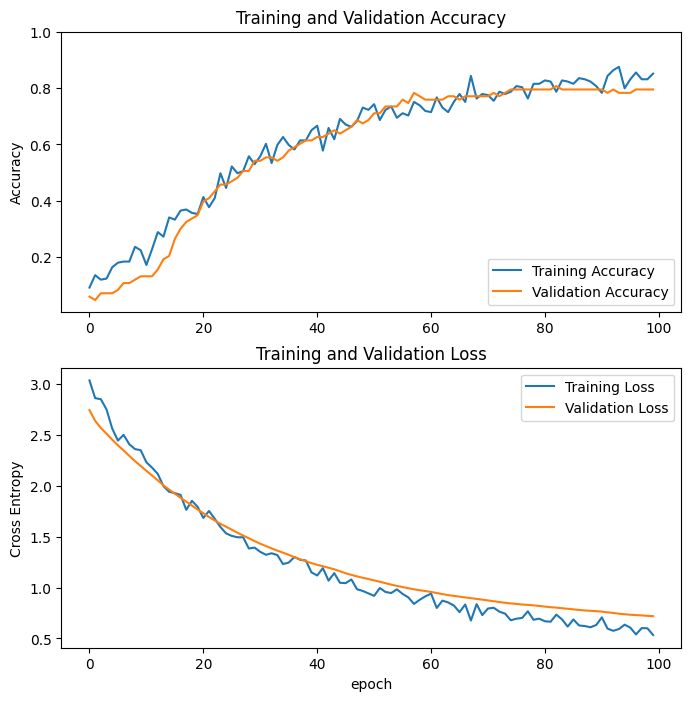

In [20]:
plot_train_val_stat(history_mobile_netv2)

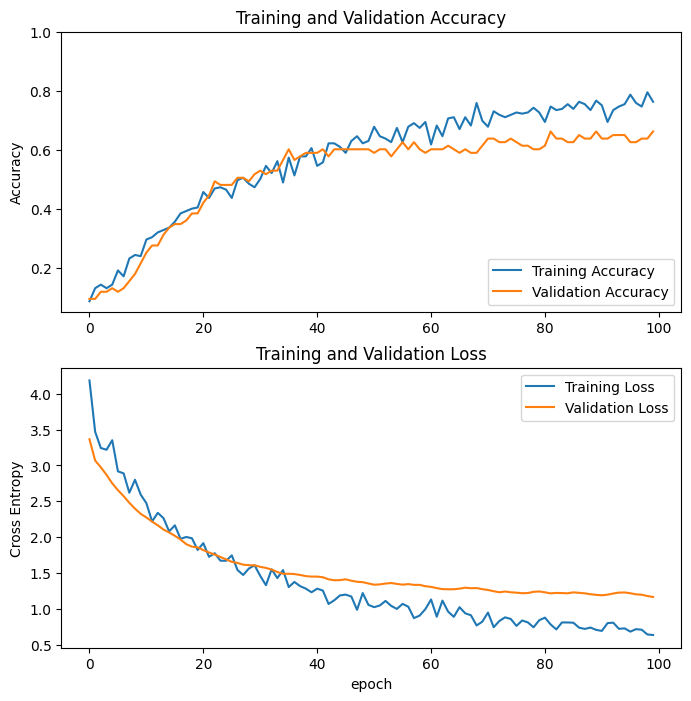

In [21]:
plot_train_val_stat(history_inception_v3)

In [22]:
def make_predictions(model, model_name):

    y_true = []
    y_pred = []
    image_features = []

    model.evaluate(test_ds)

    # Iterate over the test dataset
    for images, labels in test_ds:

        # Get True Labels
        y_true.extend(labels.numpy()) # Use .numpy() to extract data

        # Get Predictions
        predictions = model.predict(images)
        # Convert prediction probabilities to class index (e.g., [0.1, 0.9] -> 1)
        y_pred.extend(np.argmax(predictions, axis=1))

        # Saved the images
        image_features.extend(images)

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    cr = classification_report(y_true, y_pred, target_names=class_names)

    print(cr)

    # Display the matrix using matplotlib
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    return y_true, y_pred, image_features



In [23]:
def show_images(images, predictions):
    plt.figure(figsize=(15, 15))
    for i in range(15):
       ax = plt.subplot(5, 5, i + 1)
       plt.imshow(images[i])
       plt.title(class_names[predictions[i]])
       plt.axis("off")

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7802 - loss: 0.7857
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
                   precision    recall  f1-score   support

        allen key       0.86      0.75      0.80         8
           chisel       0.75      0.75      0.75         8
           hammer       0.43      0.38      0.40         8
           mallet       0.82      0.90      0.86        10
            plier       1.00      0.90      0.95        10
              saw       0.91      1.00      0.95        10
         scrapper       0.83      1.00      0.91        10
screw driver flat       0.50      0.29      0.36         7
screw driver star       0.58      1.00      0.74         7
          spanner       1.00      0.62      0.77         8

         accuracy                           0.78        86
        macro avg       0.77      0.76      0.75        86
     weighted avg       0.78      0.78      0.77   

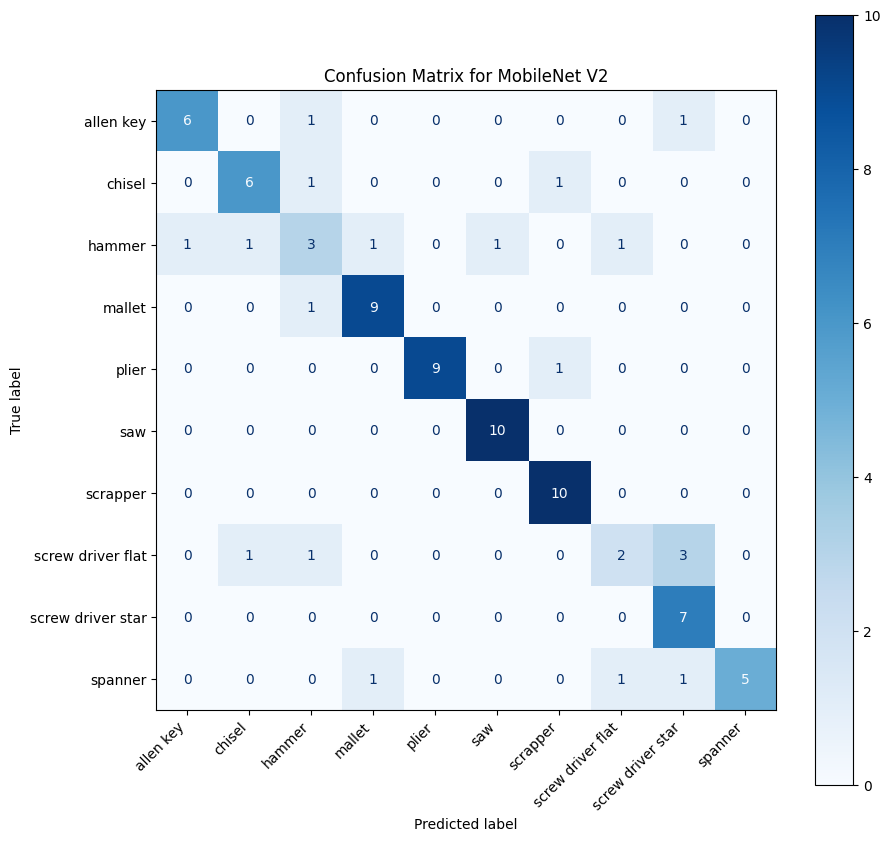

In [24]:
mobile_netv2_pred = make_predictions(mobile_netv2, "MobileNet V2")

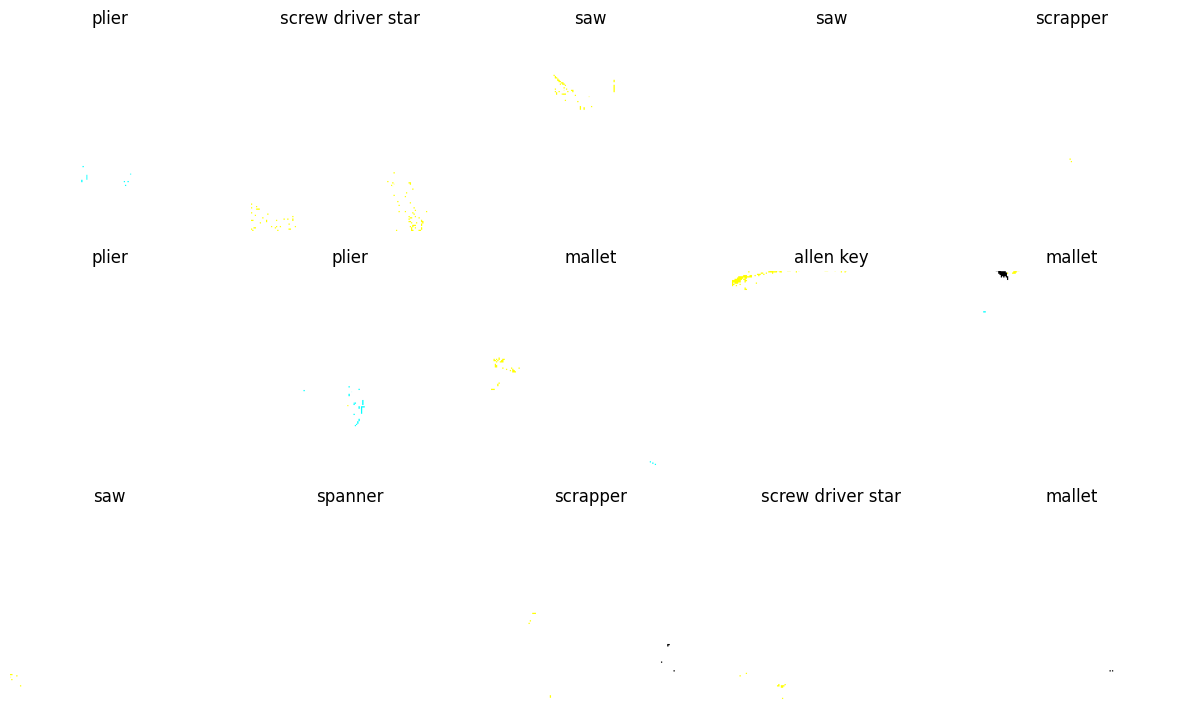

In [25]:
show_images(mobile_netv2_pred[2], mobile_netv2_pred[1])

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7394 - loss: 0.7210
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
                   precision    recall  f1-score   support

        allen key       0.88      0.88      0.88         8
           chisel       1.00      0.50      0.67         8
           hammer       0.46      0.75      0.57         8
           mallet       0.45      0.50      0.48        10
            plier       0.90      0.90      0.90        10
              saw       1.00      0.90      0.95        10
         scrapper       0.89      0.80      0.84        10
screw driver flat       0.33      0.29      0.31         7
screw driver star       0.86      0.86      0.86         7
          spanner       0.67      0.75      0.71         8

         accuracy                           0.72        86
        macro avg       0.74      0.71      0.71        86
     weighted avg       0.75      0.72      0.73  

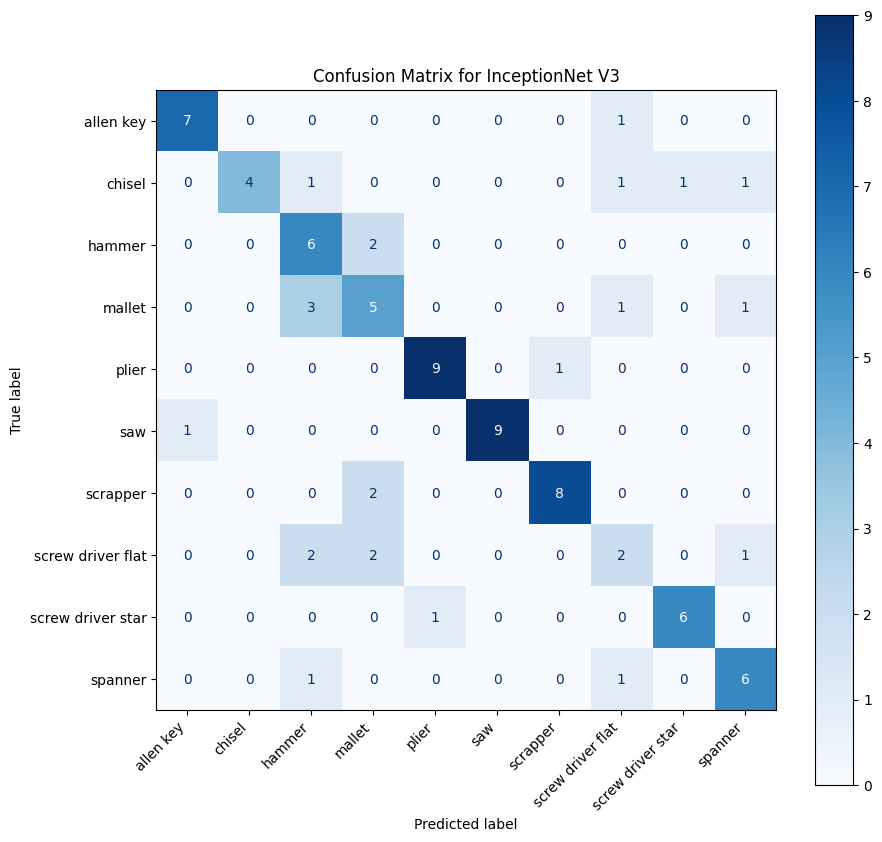

In [26]:
inception_netv3_pred = make_predictions(inception_v3, "InceptionNet V3")

In [27]:
history_mobile_netv2_finetune = mobile_netv2_finetune.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.1566 - loss: 2.8290 - val_accuracy: 0.1687 - val_loss: 2.6231
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.2838 - loss: 2.1897 - val_accuracy: 0.4217 - val_loss: 1.9806
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5469 - loss: 1.4699 - val_accuracy: 0.5904 - val_loss: 1.5549
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.6709 - loss: 1.1394 - val_accuracy: 0.6145 - val_loss: 1.2492
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.8084 - loss: 0.8622 - val_accuracy: 0.6867 - val_loss: 1.0396
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8080 - loss: 0.7245 - val_accuracy: 0.7229 - val_loss: 0.8858
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8300 - loss: 0.6496 - val_accuracy: 0.7349 - val_loss: 0.7694
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8592 - loss: 0.5219 - val_accuracy: 0.7470 - val_loss: 0.7063


In [28]:
history_inception_v3_finetune = inception_v3_finetune.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.1192 - loss: 2.3695 - val_accuracy: 0.3133 - val_loss: 2.2109
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.3867 - loss: 1.9040 - val_accuracy: 0.4337 - val_loss: 1.9061
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.5885 - loss: 1.4991 - val_accuracy: 0.5422 - val_loss: 1.6660
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.6511 - loss: 1.2217 - val_accuracy: 0.5783 - val_loss: 1.4175
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8154 - loss: 0.8457 - val_accuracy: 0.6627 - val_loss: 1.1365
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8240 - loss: 0.7769 - val_accuracy: 0.7108 - val_loss: 0.9040
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8739 - loss: 0.5396 - val_accuracy: 0.7711 - val_loss: 0.7787
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.9025 - loss: 0.4839 - val_accuracy: 0.7831 - val_loss: 0.6776


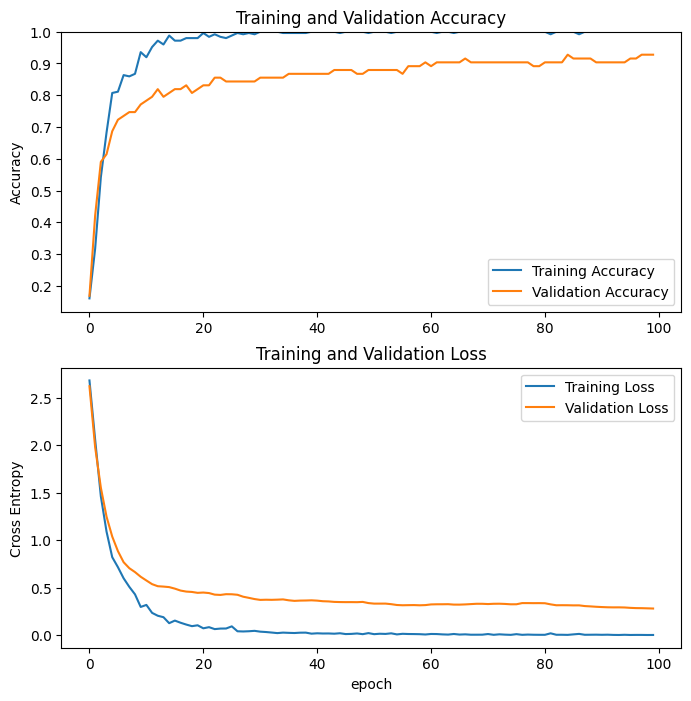

In [29]:
plot_train_val_stat(history_mobile_netv2_finetune)

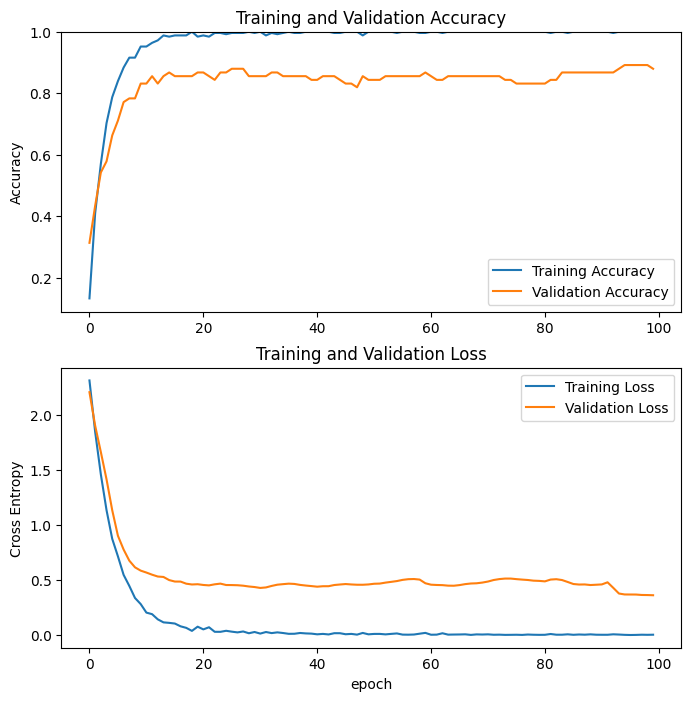

In [30]:
plot_train_val_stat(history_inception_v3_finetune)

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9046 - loss: 0.2629


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
                   precision    recall  f1-score   support

        allen key       0.80      1.00      0.89         8
           chisel       1.00      0.88      0.93         8
           hammer       1.00      0.88      0.93         8
           mallet       0.83      1.00      0.91        10
            plier       1.00      1.00      1.00        10
              saw       1.00      1.00      1.00        10
         scrapper       1.00      1.00      1.00        10
screw driver flat       1.00      0.71      0.83         7
screw driver star       0.70      1.00      0.82         7
          spanner       1.00      0.62      0.77         8

         accuracy                           0.92        86
        macro avg       0.93      0.91      0.91        86
     weighted avg       0.94      0.92      0.92        86



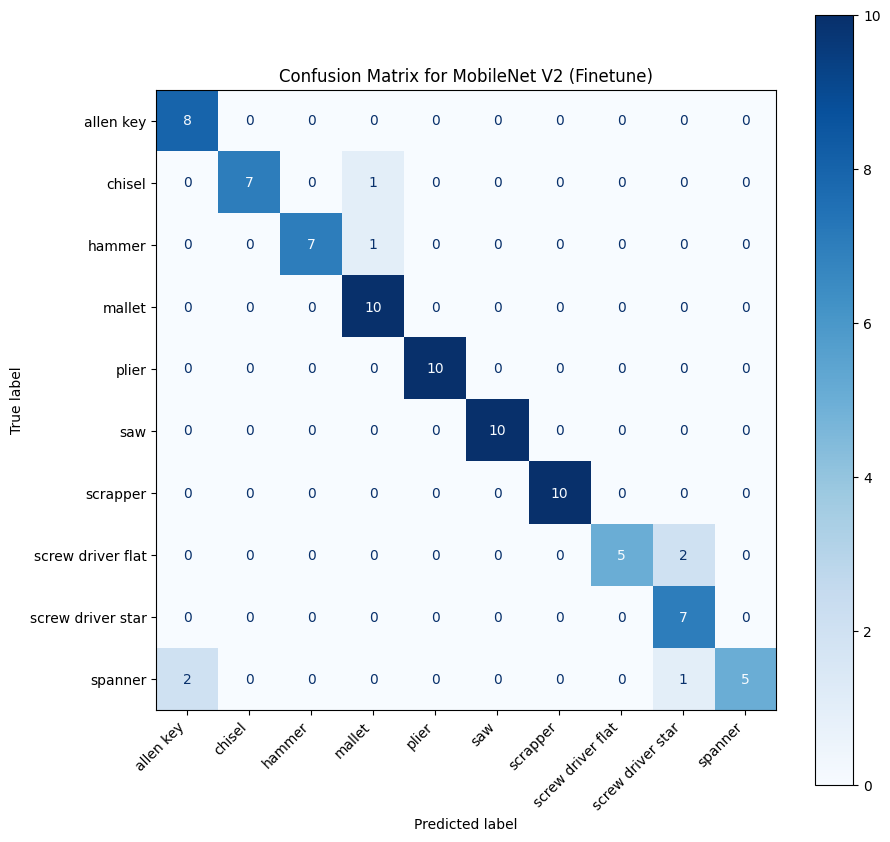

In [31]:
mobile_netv2_finetuned_pred = make_predictions(mobile_netv2_finetune, "MobileNet V2 (Finetune)")

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9027 - loss: 0.2242
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
                   precision    recall  f1-score   support

        allen key       1.00      1.00      1.00         8
           chisel       1.00      0.88      0.93         8
           hammer       0.86      0.75      0.80         8
           mallet       0.75      0.90      0.82        10
            plier       1.00      1.00      1.00        10
              saw       0.91      1.00      0.95        10
         scrapper       0.90      0.90      0.90        10
screw driver flat       1.00      0.71      0.83         7
screw driver star       0.78      1.00      0.88         7
          spanner       1.00      0.88      0.93         8

         accuracy                           0.91        86
        macro avg       0.92      0.90      0.90        86
     weighted avg       0.92      0.91      0.91  

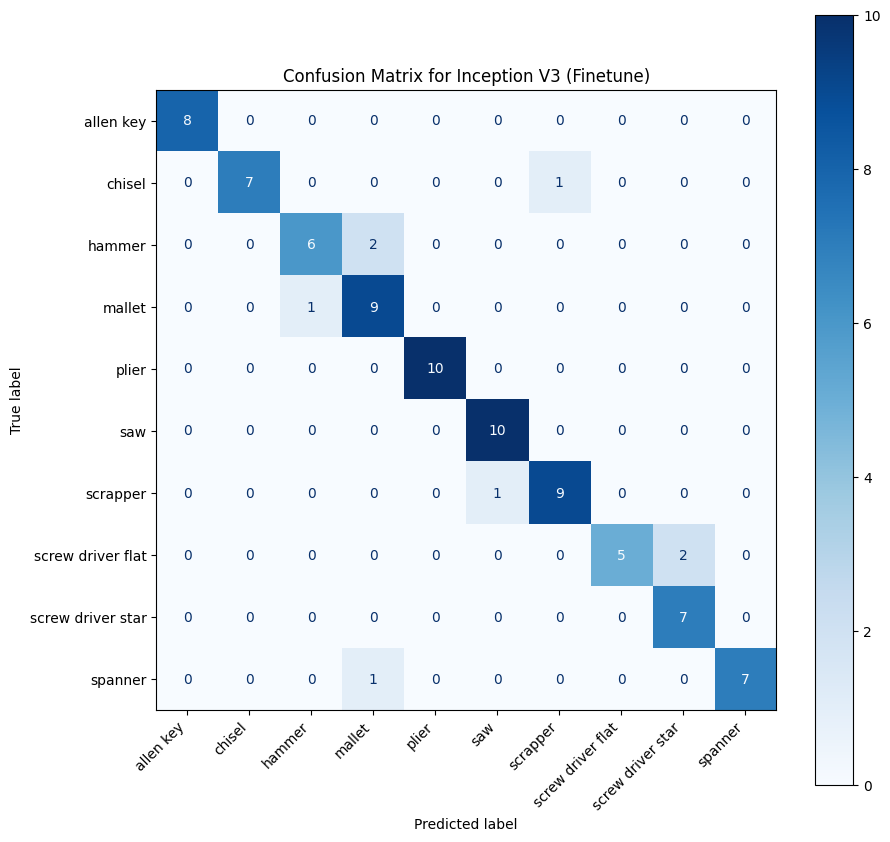

In [32]:
inception_netv3_finetune_pred = make_predictions(inception_v3_finetune, "Inception V3 (Finetune)")